## Calculate Sensitivity of Concentration to Rate Constants with CasADi
The reaction example is a parameter estimation example from James Rawlings [reactor design book](https://sites.engineering.ucsb.edu/~jbraw/chemreacfun/). The code for the example in octave is in this [location](https://github.com/rawlings-group/paresto/blob/master/examples/green_book/ABC.m). 

$$ A \xrightarrow{k_1} B \xrightarrow{k_2} C$$

In [1]:
from casadi import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Define concentration variables
cA = MX.sym('cA')
cB = MX.sym('cB')
cC = MX.sym('cC')

In [3]:
# group concentation variables into a variable x
x = vertcat(cA, cB, cC)
x

MX(vertcat(cA, cB, cC))

In [4]:
# Define rate constants
k1 = MX.sym('k1')
k2 = MX.sym('k2')
# group rate constants into a parameter variable p
p = vertcat(k1, k2)
p

MX(vertcat(k1, k2))

In [5]:
# Define rates for ODE
r1 = k1 * cA
r2 = k2 * cB
dcA = -r1
dcB = r1 - r2
dcC = r2

In [6]:
ode_rhs = vertcat(dcA, dcB, dcC)
ode_rhs

MX(@1=(k1*cA), @2=(k2*cB), vertcat((-@1), (@1-@2), @2))

In [7]:
# define ode 
ode = {'x': x, 'p': p, 'ode': ode_rhs}
ode

{'x': MX(vertcat(cA, cB, cC)),
 'p': MX(vertcat(k1, k2)),
 'ode': MX(@1=(k1*cA), @2=(k2*cB), vertcat((-@1), (@1-@2), @2))}

In [8]:
# time grid
tgrid = np.linspace(0, 5)
tgrid

array([0.        , 0.10204082, 0.20408163, 0.30612245, 0.40816327,
       0.51020408, 0.6122449 , 0.71428571, 0.81632653, 0.91836735,
       1.02040816, 1.12244898, 1.2244898 , 1.32653061, 1.42857143,
       1.53061224, 1.63265306, 1.73469388, 1.83673469, 1.93877551,
       2.04081633, 2.14285714, 2.24489796, 2.34693878, 2.44897959,
       2.55102041, 2.65306122, 2.75510204, 2.85714286, 2.95918367,
       3.06122449, 3.16326531, 3.26530612, 3.36734694, 3.46938776,
       3.57142857, 3.67346939, 3.7755102 , 3.87755102, 3.97959184,
       4.08163265, 4.18367347, 4.28571429, 4.3877551 , 4.48979592,
       4.59183673, 4.69387755, 4.79591837, 4.89795918, 5.        ])

In [99]:
## Simulate over time grid tgrid

# initial concentration (ca0, cb0, cc0)
xinit = [1.0, 0.0, 0.0]
# rate constants
kfix = [2.0, 1.0]

# concentration list
conc = []
# list to get sensitivity dx/dp at each point of time grid
sens = []

tprev = 0.0
x0 = xinit.copy()
for (i, t) in enumerate(tgrid[1:]):
    # time interval to integrate
    tdel = t - tprev
    # integrator function definition
    F = integrator('F','cvodes',ode,{'tf':tdel})
    # result of integrator function as a function of x0 and p
    res = F(x0 = x0, p = p)
    # x at the final time becomes initial x0 for the next integration
    x0 = res['xf']
    # conc at time t
    c = Function('c', [p], [x0])
    conc.append(c(kfix))
    # jacobian dx/dp at time t
    dxdp = jacobian(x0, p)
    J = Function('J', [p], [dxdp])
    sens.append(J(kfix))
    tprev = t

In [100]:
conc2 = np.array([x.full().T[0,:] for x in conc])
conc2 = np.vstack((xinit, conc2))
conc_t = np.concatenate([tgrid[np.newaxis].T, conc2], axis = 1)
conc_t[:5,:]

array([[0.        , 1.        , 0.        , 0.        ],
       [0.10204082, 0.81539579, 0.17519379, 0.00941041],
       [0.20408163, 0.6648702 , 0.3010512 , 0.0340786 ],
       [0.30612245, 0.54213239, 0.38832815, 0.06953946],
       [0.40816327, 0.44205276, 0.44563533, 0.11231191]])

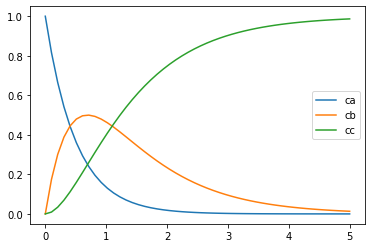

In [101]:
# Plot conc vs time
fig, ax = plt.subplots()
ax.plot(tgrid, conc2[:, 0], label = 'ca')
ax.plot(tgrid, conc2[:, 1], label = 'cb')
ax.plot(tgrid, conc2[:, 2], label = 'cc')
ax.legend()

## Analytical solution of concentration vs time
$$ 
\begin{eqnarray}
c_A(t) &=& e^{-k_1t} \\
c_B(t) &=& \frac{k_1}{k_1 - k_2}(e^{-k_1t} - e^{-k_2t}) \\
c_C(t) &=& c_A(0) - c_A(t) - c_B(t) 
\end{eqnarray}
$$

## Analytical calculation of sensitivity

$$ 
\begin{array}{c|c}
\frac{dc_A}{dk_1} = -te^{-k_1t}  &
\frac{dc_B}{dk_2} = 0 \\
\frac{dc_B}{dk_1} = \frac{k_2}{(k_2-k_1)^2}(e^{-k_1t}-e^{-k_2t}) - \frac{k_1t}{k_2-k_1}e^{-k_1t} &
\frac{dc_B}{dk_2} = -\frac{k_1}{(k_2-k_1)^2}(e^{-k_1t}-e^{-k_2t}) + \frac{k_1t}{k_2-k_1}e^{-k_2t} \\
\frac{dc_c}{dk_1} = -\frac{dc_A}{dk_1} - \frac{dc_B}{dk_1} &
\frac{dc_c}{dk_2} = -\frac{dc_A}{dk_2} - \frac{dc_B}{dk_2} 
\end{array}
$$


In [102]:
# matrix of sensitivities at each time point form casadi
sens2 = np.array([x.full() for x in sens])

In [114]:
# Calculate analytical sensitivity of ca to k1 and k2
dca_dk1_analy = -tgrid * np.exp(-kfix[0] * tgrid)
dca_dk2_analy = 0
# Calculate analytical sensitivity of cb to k1 and k2
dcb_dk1_analy = (kfix[1]/(kfix[1] - kfix[0])**2)*(np.exp(-kfix[0] * tgrid) - np.exp(-kfix[1] * tgrid)) - \
                     (kfix[0] * tgrid / (kfix[1] - kfix[0]))*np.exp(-kfix[0] * tgrid)
dcb_dk2_analy = (-kfix[0]/(kfix[1] - kfix[0])**2)*(np.exp(-kfix[0] * tgrid) - np.exp(-kfix[1] * tgrid)) + \
                     (kfix[0] * tgrid / (kfix[1] - kfix[0]))*np.exp(-kfix[1] * tgrid)

# Calculate analytical sensitivity of cc to k1 and k2
dcc_dk1_analy = -dca_dk1_analy - dcb_dk1_analy
dcc_dk2_analy = -dca_dk2_analy - dcb_dk2_analy

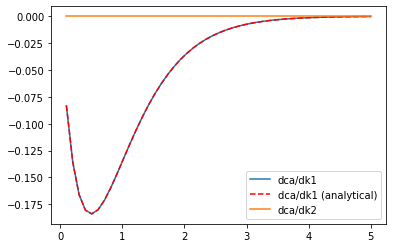

In [108]:
# plot sensitivity of ca to k1 and k2
fig, ax = plt.subplots()
ax.plot(tgrid[1:], sens2[:, 0, 0], label = 'dca/dk1')
ax.plot(tgrid[1:], dca_dk1_analy[1:], '--r', label = 'dca/dk1 (analytical)')
ax.plot(tgrid[1:], sens2[:, 0, 1], label = 'dca/dk2')
ax.legend()

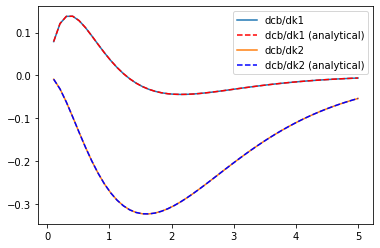

In [113]:
# plot sensitivity of cb to k1 and k2
fig, ax = plt.subplots()
ax.plot(tgrid[1:], sens2[:, 1, 0], label = 'dcb/dk1')
ax.plot(tgrid[1:], dcb_dk1_analy[1:], '--r', label = 'dcb/dk1 (analytical)')
ax.plot(tgrid[1:], sens2[:, 1, 1], label = 'dcb/dk2')
ax.plot(tgrid[1:], dcb_dk2_analy[1:], '--b', label = 'dcb/dk2 (analytical)')
ax.legend()

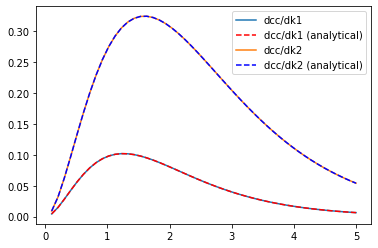

In [115]:
# plot sensitivity of cc to k1 and k2
fig, ax = plt.subplots()
ax.plot(tgrid[1:], sens2[:, 2, 0], label = 'dcc/dk1')
ax.plot(tgrid[1:], dcc_dk1_analy[1:], '--r', label = 'dcc/dk1 (analytical)')
ax.plot(tgrid[1:], sens2[:, 2, 1], label = 'dcc/dk2')
ax.plot(tgrid[1:], dcc_dk2_analy[1:], '--b', label = 'dcc/dk2 (analytical)')
ax.legend()